## load libraries

In [38]:
library(here)
library(stringr)
library(dplyr)
library(ggplot2)
library(Seurat)
library(purrr)
library(readr)
library(patchwork)
library(scCustomize)
library(tidyverse)
library(reticulate)
library(harmony)
#library(SeuratDisk)

## load data

In [21]:
filtered_seurat <- readRDS(file = here("seurat/filtered_seurat.rds"))
filtered_seurat

An object of class Seurat 
32521 features across 11105 samples within 1 assay 
Active assay: RNA (32521 features, 0 variable features)
 2 layers present: counts.control, counts.high_glucose

## Normalization

In [22]:
filtered_seurat <- Seurat::SCTransform(filtered_seurat,
    assay = 'RNA',
    new.assay.name = 'SCT',
    vst.flavor = "v2",
    variable.features.n = 4000,
    return.only.var.genes = TRUE,
    min_cells = 3,
    verbose = TRUE)

filtered_seurat

Running SCTransform on assay: RNA

Running SCTransform on layer: counts.control

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Variance stabilizing transformation of count matrix of size 23052 by 7709

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



In [ ]:
normalized_seurat <- PrepSCTFindMarkers(filtered_seurat)

Found 2 SCT models. Recorrecting SCT counts using minimum median counts: 7177



In [ ]:
saveRDS(normalized_seurat, file = here("seurat/normalized_seurat.rds"))

In [ ]:
normalized_seurat <- readRDS(file = here("seurat/normalized_seurat.rds"))
normalized_seurat

An object of class Seurat 
56194 features across 11105 samples within 2 assays 
Active assay: SCT (23673 features, 4000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

## Dimensionality reduction

In [ ]:
normalized_seurat <- RunPCA(normalized_seurat,
                     assay = 'SCT',
                     npcs = 30)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 59 features requested have not been scaled (running reduction without them): serpina1l, serpina1, sycn.2, zgc:112265, ttr, leg1.1, cfhl4, amy2a, si:dkey-31i7.2, muc5.3, si:ch1073-464p5.5, crp3, serpinb1l4, zgc:153968, plg, chia.1, si:ch211-131k2.2, grk1b, shbg, tnnc1a, c3a.2, BX001030.1, si:dkey-96g2.1, apoea, rom1a, krt93, crygmx, crybb1l1, CELA1 (1 of many).5, grk1a, si:dkey-7i4.24, actc1c, si:ch73-361h17.1, serpinf2a, rhol, tmem86b, itih2, si:dkeyp-57d7.4, apoba, aoc1, mybpc1, cryba2a, nkl.4, gdpd3b, krt95, cnga1b, c3a.3, tspan34, trpv6, si:dkey-77g12.1, csrp3, camkk1b, si:dkey-33m11.8, or131-2, a2ml, abcb11b, CELA1 (1 of many).3, crhb, si:ch211-250m6.7”
PC_ 1 
Positive:  hsp70.2, her6, hsp70l, id1, hsp70.3, cxcr4a, si:ch73-335l21.4, fosab, igfbp1a, hsp70.1 
	   rgs5b, dll4, hey1, her15.1, esm1, sox7, tcima, rgcc, hsp90aa1.2, her9 
	   dnajb1b, cldn5b, gadd45ba, socs3a, CABZ01030107.1,

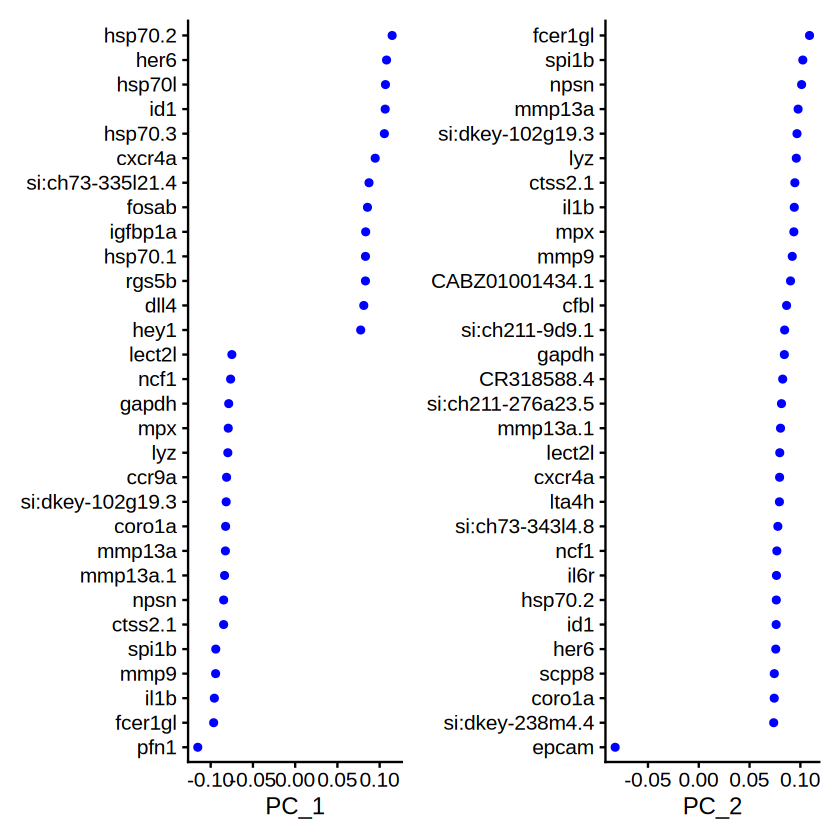

In [ ]:
VizDimLoadings(normalized_seurat,
               dims = 1:2,
               reduction = "pca")

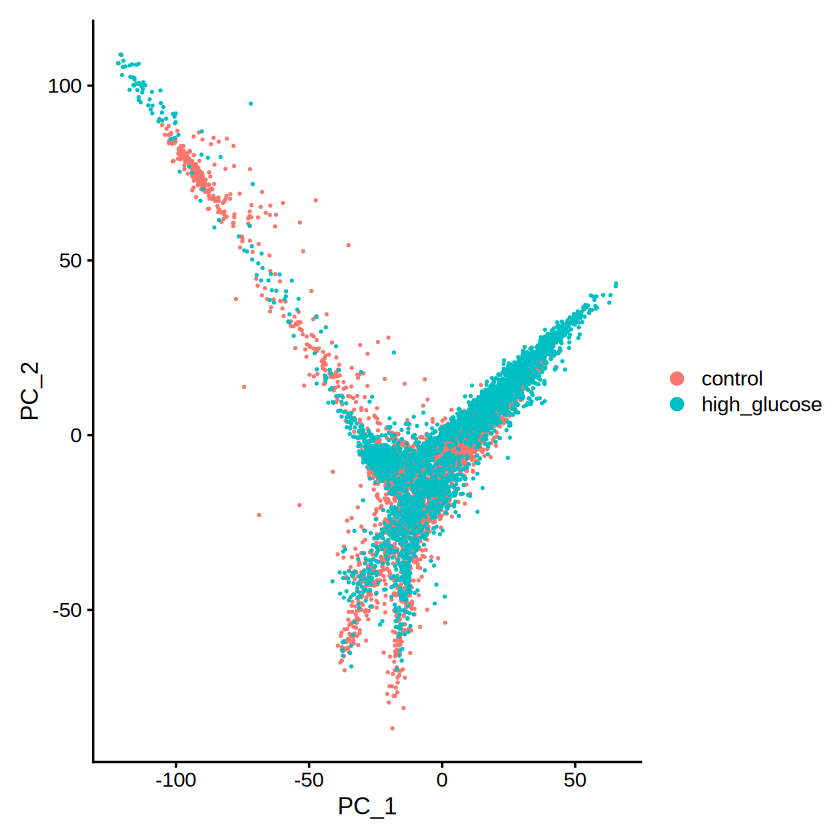

In [ ]:
DimPlot(normalized_seurat, reduction = "pca")

## Clustering

In [ ]:
normalized_seurat <- FindNeighbors(normalized_seurat,
                           reduction = "pca",
                           graph.name = c("pca_nn",
                                          "pca_snn"),
                           k.param = 10,
                           dims = 1:30)

Computing nearest neighbor graph

Computing SNN



In [ ]:
normalized_seurat@graphs

$pca_nn
A Graph object containing 11105 cells
$pca_snn
A Graph object containing 11105 cells

In [ ]:
normalized_seurat <- FindClusters(normalized_seurat,
                           graph.name = "pca_snn",
                           resolution = c(0.2, 0.3, 0.4),
                           algorithm = 4)

In [ ]:
head(normalized_seurat@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,log1p_nCount_RNA,log1p_nFeature_RNA,pct_counts_in_top_20_genes,pct_counts_mt,outlier,mt_outlier,nCount_SCT,nFeature_SCT,pca_snn_res.0.2,pca_snn_res.0.3,pca_snn_res.0.4,seurat_clusters
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>
control_AAACCCAAGACCAGCA-1,control,20307,3155,9.918770,8.057061,21.19466,3.210716,FALSE,FALSE,7014,1562,2,1,2,2
control_AAACCCAAGCCTGGAA-1,control,9374,1963,9.145802,7.582738,19.70344,1.568167,FALSE,FALSE,7629,1962,2,1,2,2
control_AAACCCACACACCTAA-1,control,10715,2117,9.279493,7.658228,21.42790,3.070462,FALSE,FALSE,7725,2115,13,15,30,30
control_AAACCCACAGAACATA-1,control,6655,1959,8.803274,7.580700,21.59279,1.066867,FALSE,FALSE,6959,1959,3,5,4,4
control_AAACCCAGTGCCCAGT-1,control,5794,1795,8.664751,7.493317,26.32033,5.229548,FALSE,FALSE,6736,1793,3,5,4,4
control_AAACCCATCATTGCGA-1,control,8002,1941,8.987572,7.571474,18.75781,2.211947,FALSE,FALSE,7456,1941,17,18,19,19


## UMAP visualization

In [ ]:
normalized_seurat <- RunUMAP(normalized_seurat,
                      reduction = "pca",
                      dims = 1:30,
                      reduction.name = "umap_pca"
)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:19:06 UMAP embedding parameters a = 0.9922 b = 1.112

10:19:06 Read 11105 rows and found 30 numeric columns

10:19:06 Using Annoy for neighbor search, n_neighbors = 30

10:19:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:19:07 Writing NN index file to temp file /tmp/RtmpWdjllZ/file46d04bb2e9b6

10:19:07 Searching Annoy index using 1 thread, search_k = 3000

10:19:08 Annoy recall = 100%

10:19:09 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors 

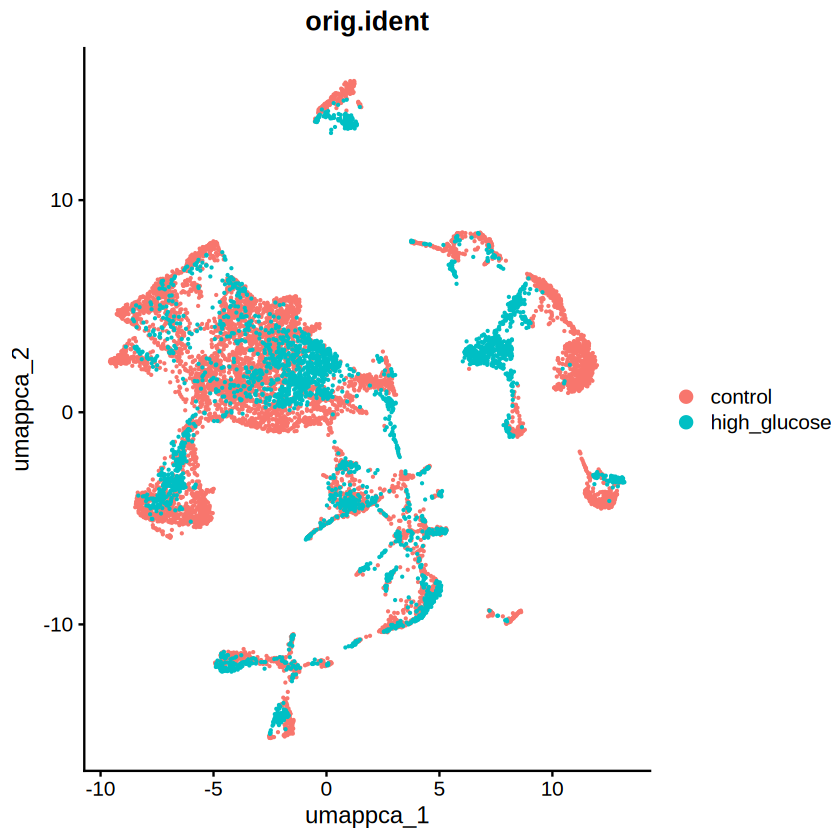

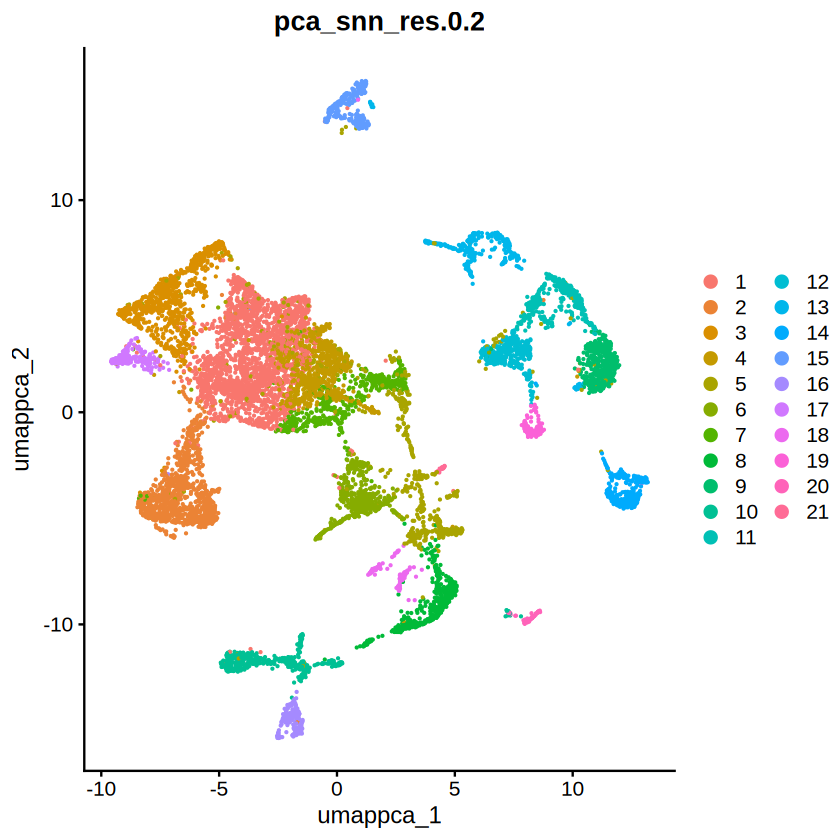

[[1]]

[[2]]

[[3]]

[[4]]


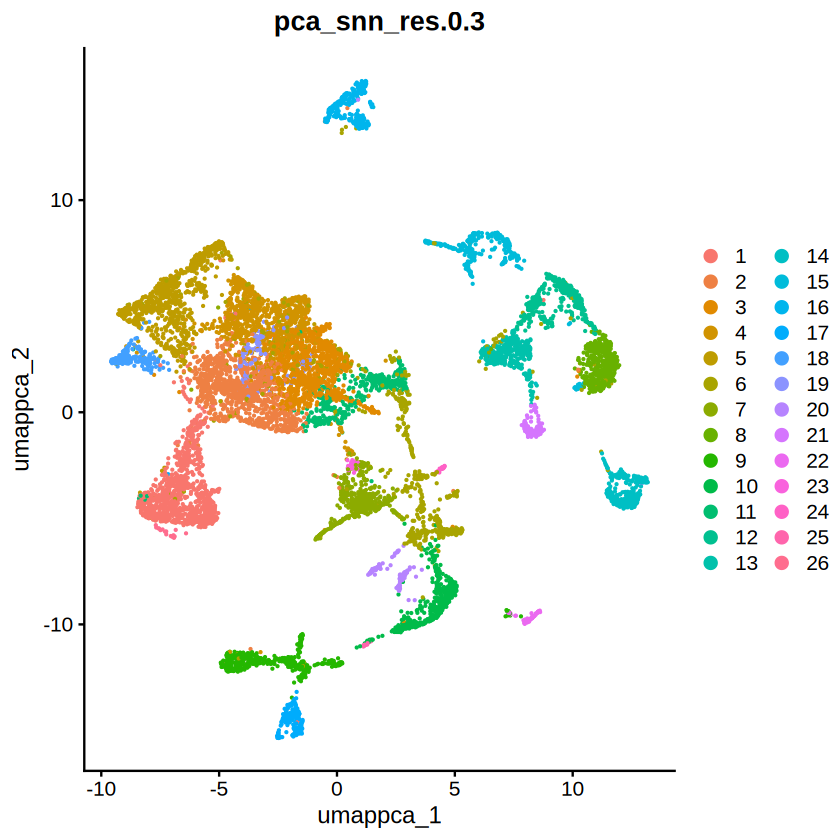

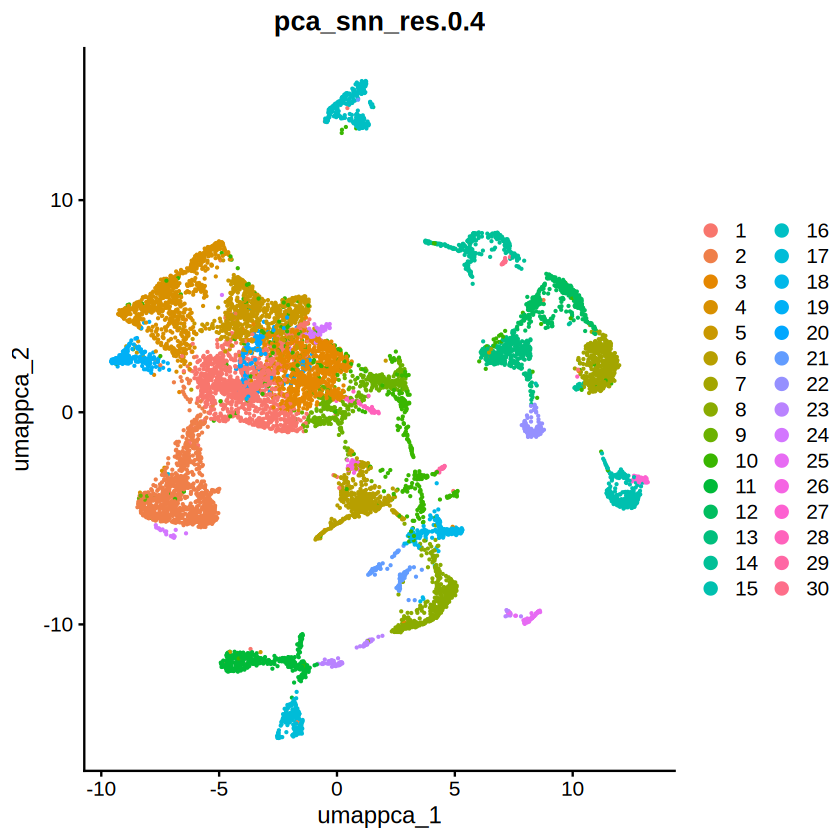

In [ ]:
DimPlot(
  normalized_seurat,
  reduction = "umap_pca",
  group.by = c('orig.ident',
               'pca_snn_res.0.2',
               'pca_snn_res.0.3',
               'pca_snn_res.0.4'),
  combine = FALSE
)

## Data integration

In [ ]:
normalized_seurat <- readRDS(file = here("seurat/normalized_seurat.rds"))
normalized_seurat

An object of class Seurat 
56194 features across 11105 samples within 2 assays 
Active assay: SCT (23673 features, 4000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

In [ ]:
normalized_seurat <- IntegrateLayers(normalized_seurat,
                              normalization.method = "SCT",
                              method = HarmonyIntegration,
                              orig.reduction = "pca",
                              new.reduction = "harmony",
                              verbose = T
)

Warning message:
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”
Warning message:
“Warning: The parameters do_pca and npcs are deprecated. They will be ignored for this function call and please remove parameters do_pca and npcs and pass to harmony cell_embeddings directly.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter tau is deprecated. It will be ignored for this function call and please remove parameter tau in future function calls. Advanced users can set value of parameter tau by using parameter .options and function harmony_options().
This warning is displayed once per session.”
Warning message:
“Warning: The parameter block.size is deprecated. It will be ignored for this function call and please remove parameter block.size in future function calls. Advanced users can set value of parameter block.size by using parameter .options and function harmony_options().
This warning is displayed once per sessi

## clustering and viz

In [12]:
saveRDS(normalized_seurat, file = here("seurat/integrated_seurat.rds"))

In [5]:
integrated_seurat <- readRDS(file = here("seurat/normalized_seurat.rds"))
integrated_seurat

An object of class Seurat 
56194 features across 11105 samples within 2 assays 
Active assay: SCT (23673 features, 4000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

In [14]:
normalized_seurat <- FindNeighbors(normalized_seurat,
                           reduction = "harmony",
                           graph.name = c("harmony_nn",
                                          "harmony_snn"),
                           k.param = 10,
                           dims = 1:30)

Computing nearest neighbor graph

Computing SNN



In [35]:
normalized_seurat <- FindClusters(normalized_seurat,
                           graph.name = "harmony_snn",
                           resolution = c(0.01,0.02,0.03,0.05, 0.1, 0.2, 0.3, 0.4),
                           algorithm = 4)

In [17]:
head(normalized_seurat@meta.data)


,orig.ident,nCount_RNA,nFeature_RNA,log1p_nCount_RNA,log1p_nFeature_RNA,pct_counts_in_top_20_genes,pct_counts_mt,outlier,mt_outlier,nCount_SCT,nFeature_SCT,harmony_snn_res.0.2,harmony_snn_res.0.3,harmony_snn_res.0.4,seurat_clusters
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>
control_AAACCCAAGACCAGCA-1,control,20307,3155,9.918770,8.057061,21.19466,3.210716,FALSE,FALSE,7014,1562,3,4,3,3
control_AAACCCAAGCCTGGAA-1,control,9374,1963,9.145802,7.582738,19.70344,1.568167,FALSE,FALSE,7629,1962,3,4,3,3
control_AAACCCACACACCTAA-1,control,10715,2117,9.279493,7.658228,21.42790,3.070462,FALSE,FALSE,7725,2115,21,24,28,28
control_AAACCCACAGAACATA-1,control,6655,1959,8.803274,7.580700,21.59279,1.066867,FALSE,FALSE,6959,1959,5,6,6,6
control_AAACCCAGTGCCCAGT-1,control,5794,1795,8.664751,7.493317,26.32033,5.229548,FALSE,FALSE,6736,1793,5,6,6,6
control_AAACCCATCATTGCGA-1,control,8002,1941,8.987572,7.571474,18.75781,2.211947,FALSE,FALSE,7456,1941,16,18,18,18


In [36]:
## UMAP visualization
normalized_seurat <- RunUMAP(normalized_seurat,
                      reduction = "harmony",
                      dims = 1:30,
                      reduction.name = "umap_harmony",
                      min.dist = 0.5
)

12:18:35 UMAP embedding parameters a = 0.583 b = 1.334

12:18:35 Read 11105 rows and found 30 numeric columns

12:18:35 Using Annoy for neighbor search, n_neighbors = 30

12:18:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:18:35 Writing NN index file to temp file /tmp/Rtmp66WhCK/file6f8751f5c601

12:18:35 Searching Annoy index using 1 thread, search_k = 3000

12:18:37 Annoy recall = 100%

12:18:38 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

12:18:38 Initializing from normalized Laplacian + noise (using RSpectra)

12:18:38 Commencing optimization for 200 epochs, with 461940 positive edges

12:18:41 Optimization finished



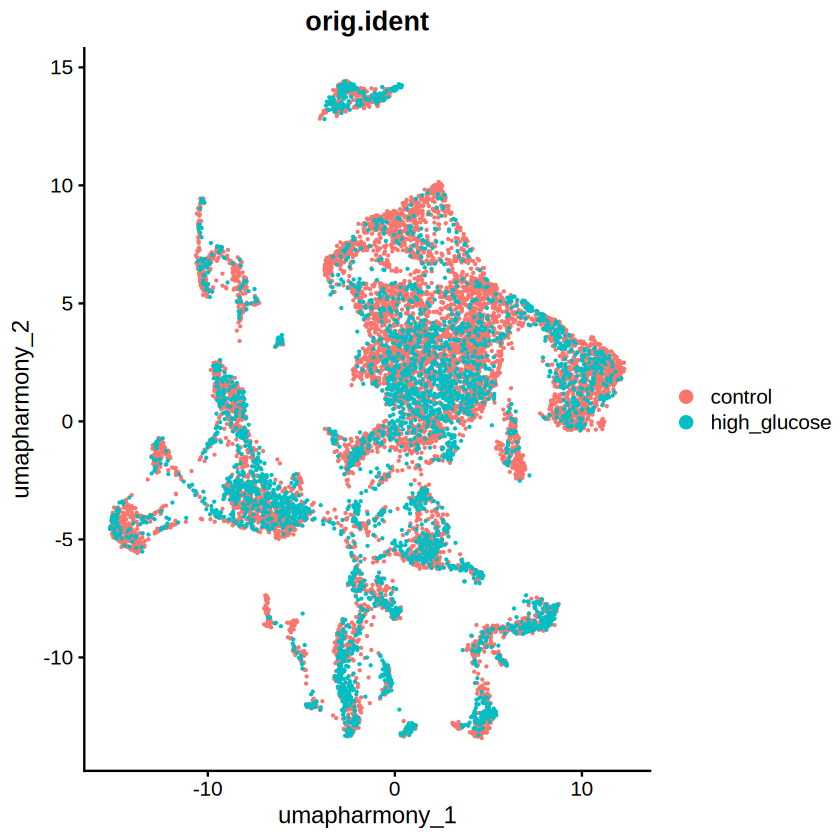

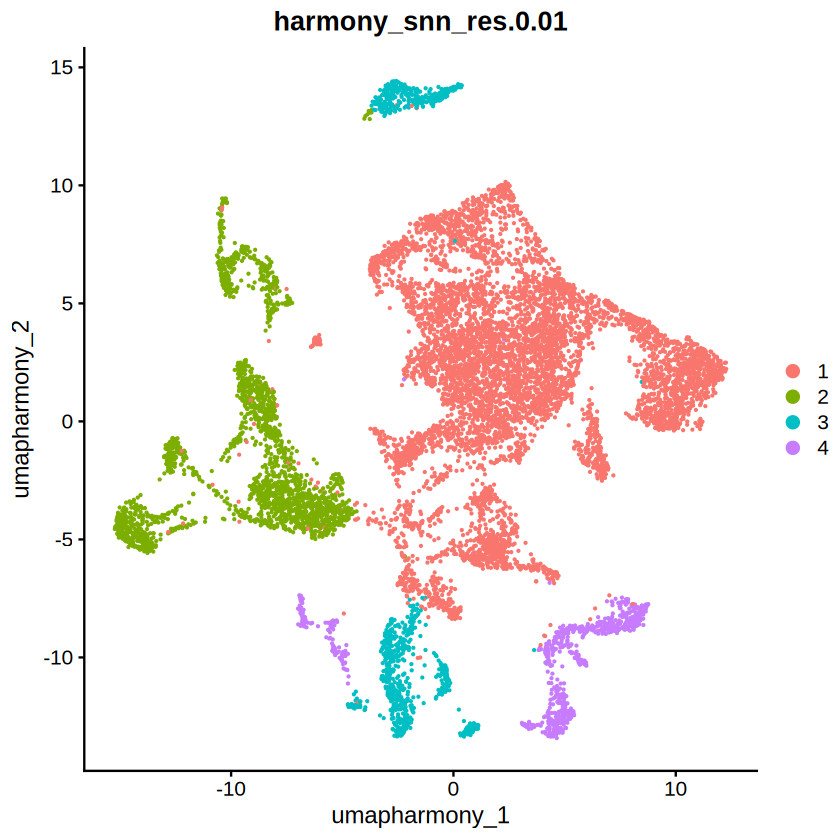

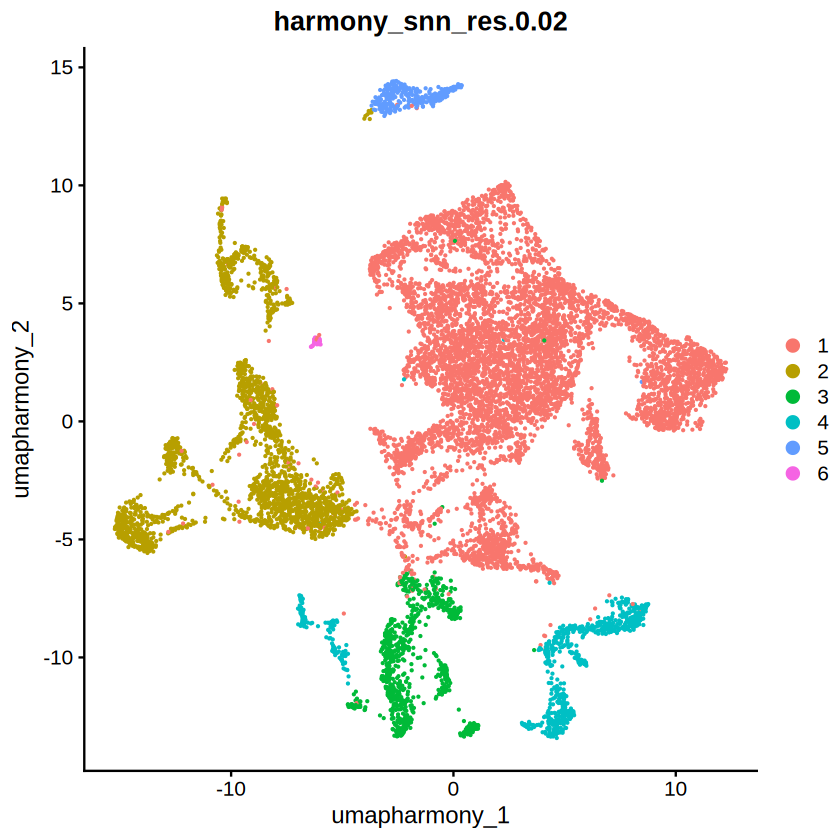

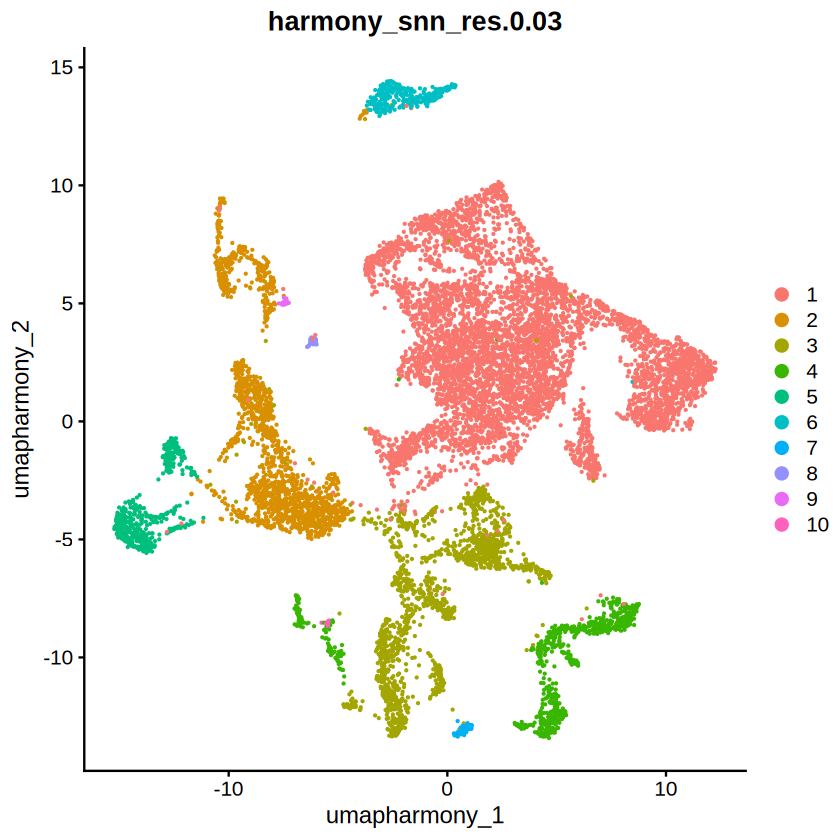

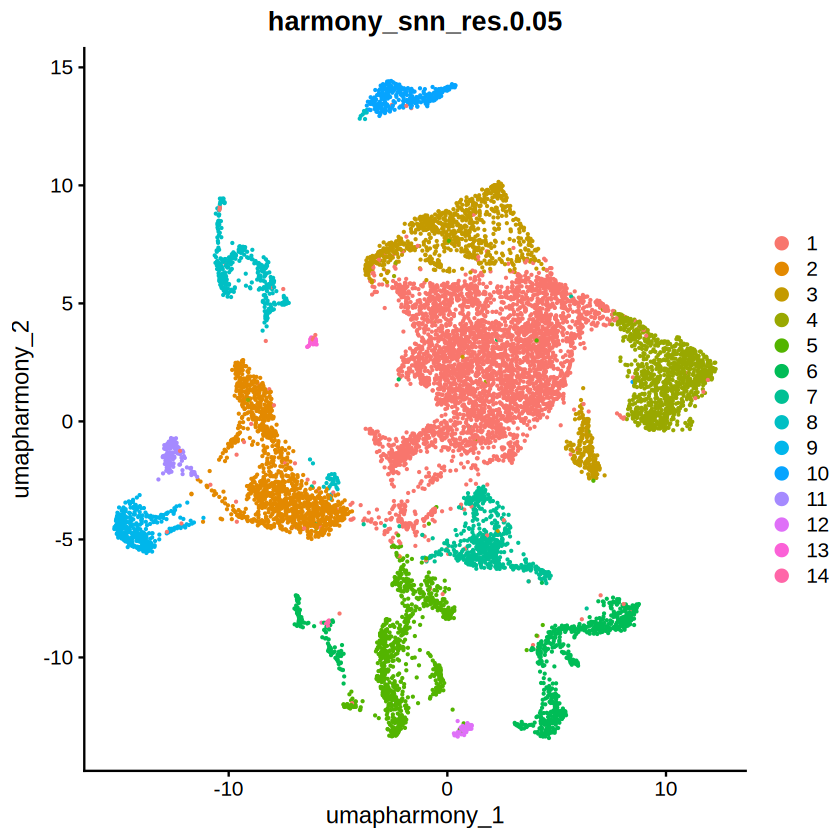

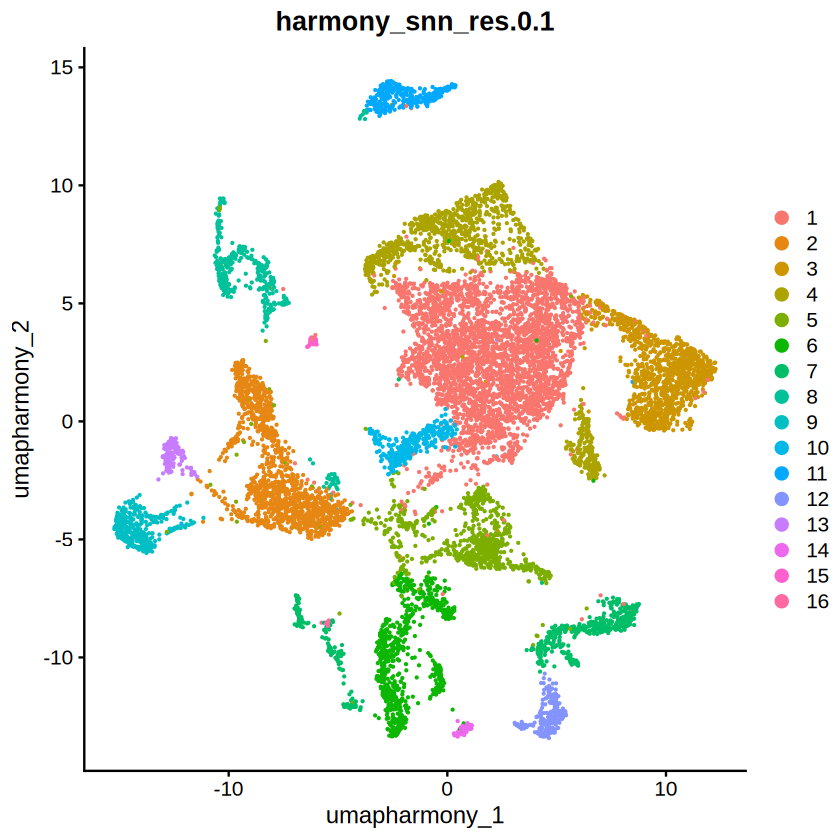

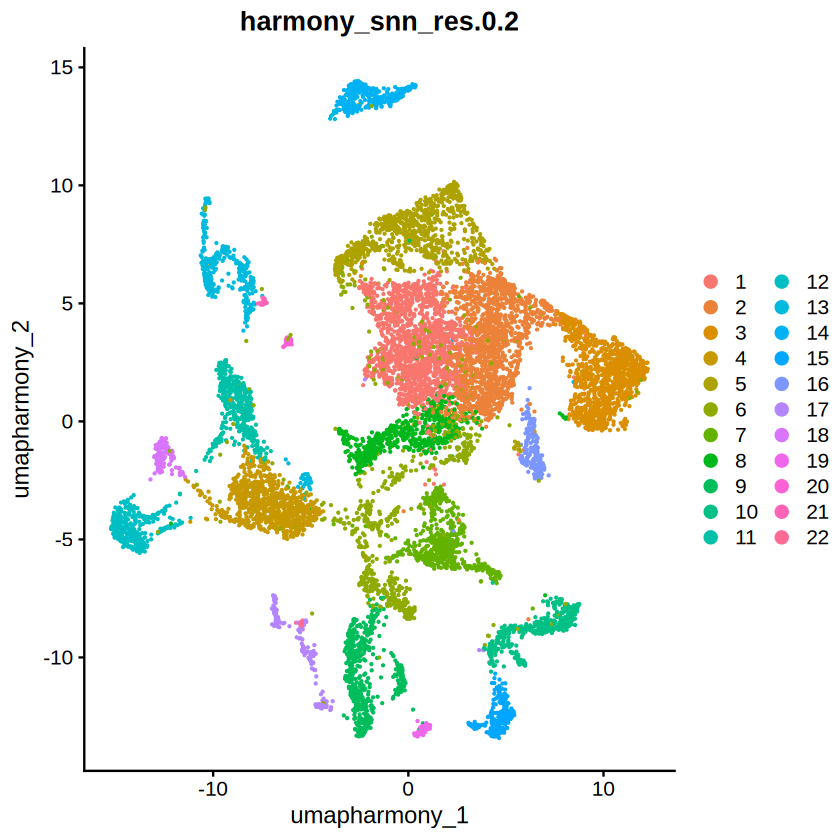

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]


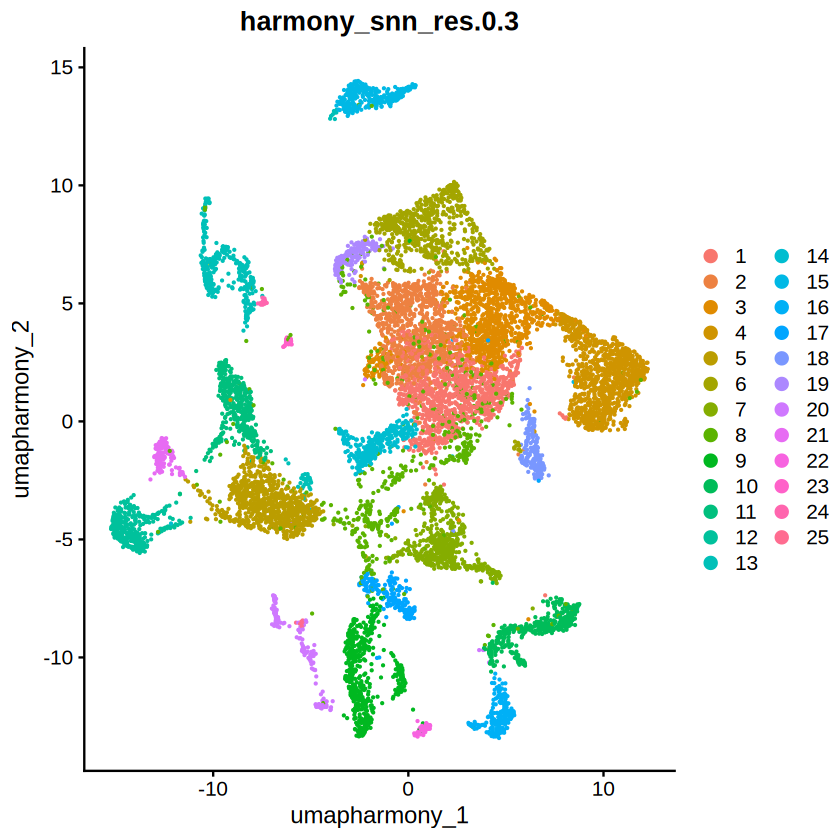

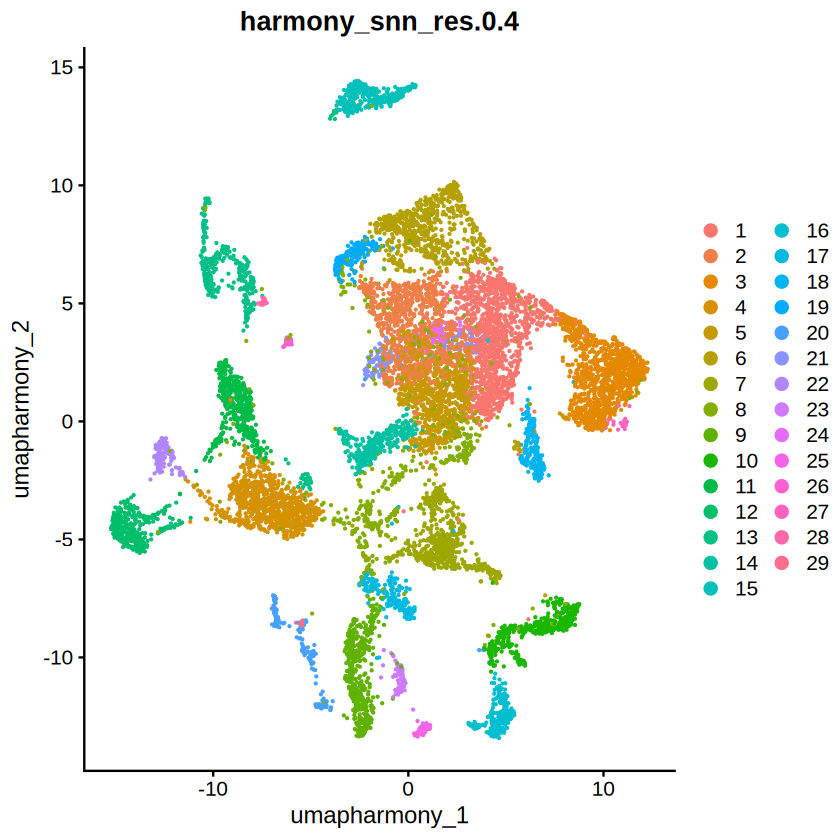

In [37]:
DimPlot(
  normalized_seurat,
  reduction = "umap_harmony",
  group.by = c('orig.ident',
               'harmony_snn_res.0.01',
               'harmony_snn_res.0.02',
               'harmony_snn_res.0.03',
               'harmony_snn_res.0.05',
               'harmony_snn_res.0.1',
               'harmony_snn_res.0.2',
               'harmony_snn_res.0.3',
               'harmony_snn_res.0.4'),
  combine = FALSE
)

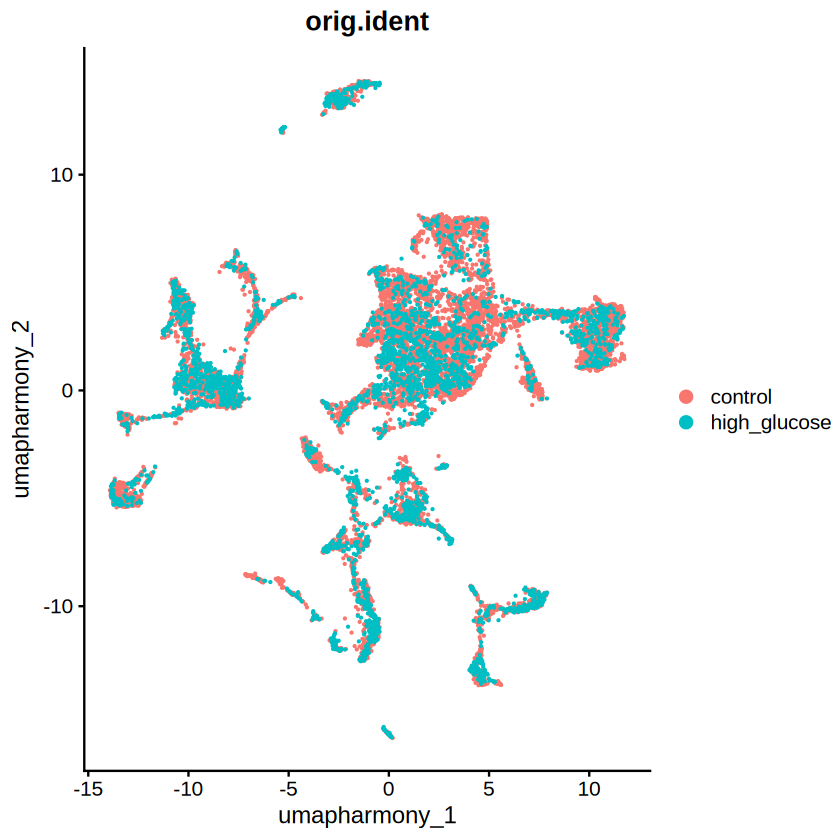

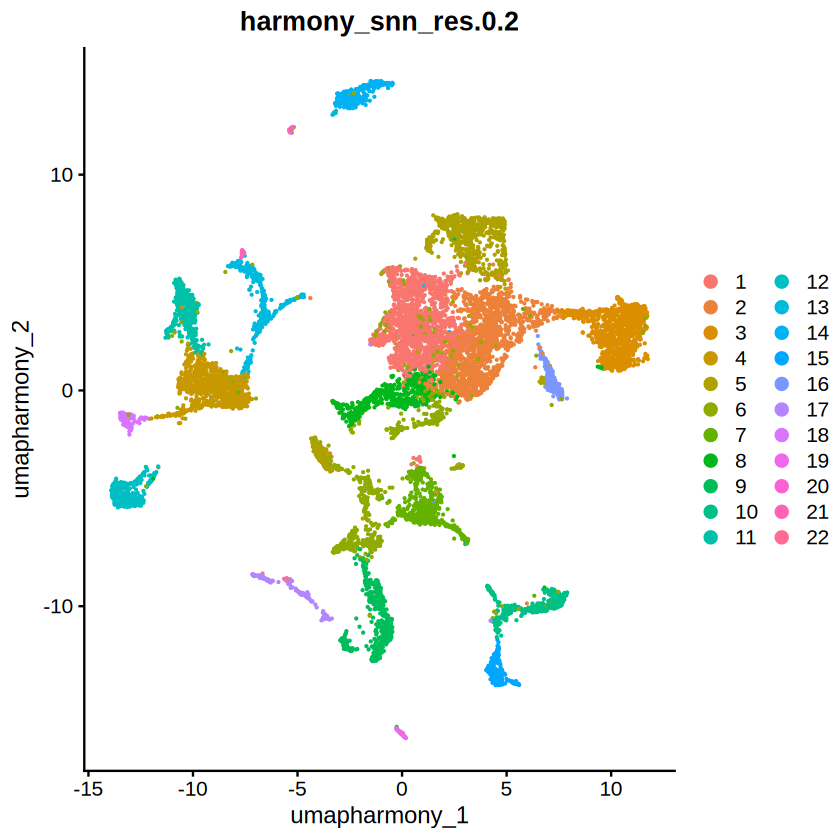

[[1]]

[[2]]

[[3]]

[[4]]


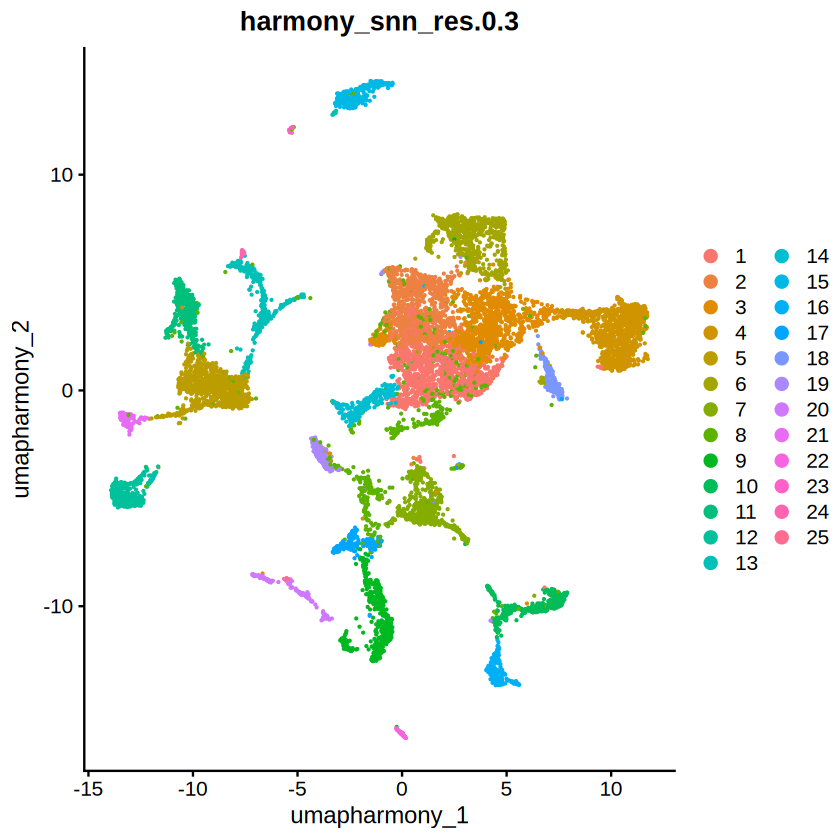

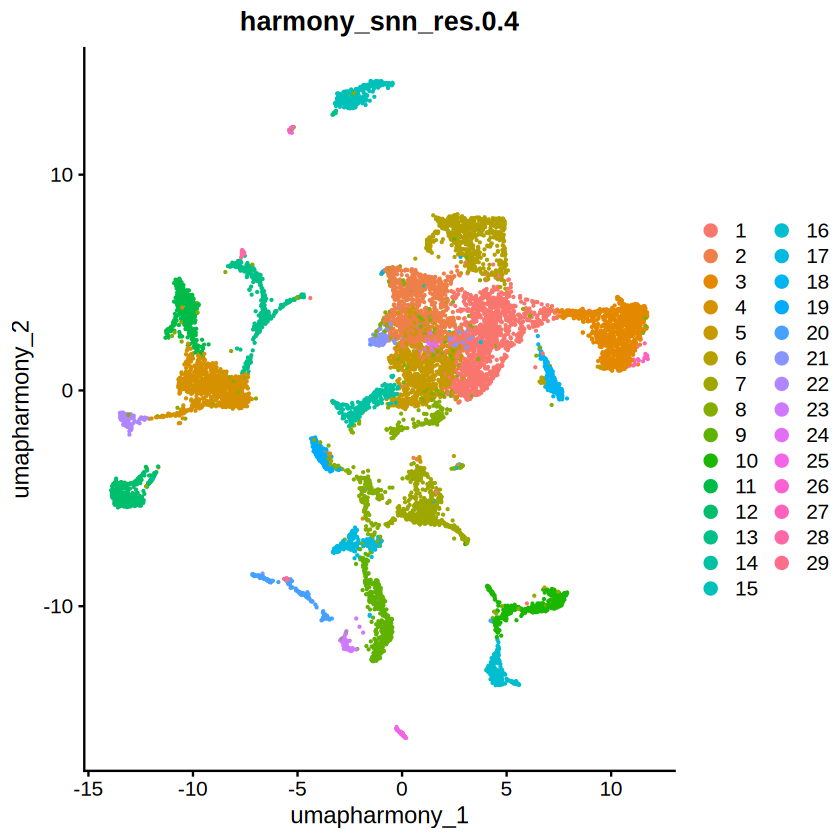

In [19]:
DimPlot(
  normalized_seurat,
  reduction = "umap_harmony",
  group.by = c('orig.ident',
               'harmony_snn_res.0.2',
               'harmony_snn_res.0.3',
               'harmony_snn_res.0.4'),
  combine = FALSE
)